In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, re

from astropy.table import Table, join, Column

from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
from thejoker import compute_likelihoods, likelihood

import astropy.units as u
import corner

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
ls ../results/

results_rvs.png     results_video.hdf5


In [6]:
fname = '../rvs.csv'
data = Table.read(fname)

In [7]:
data

JD,RV_wobble,RV_err_wobble,RV_pipeline,RV_err_pipeline
float64,float64,float64,float64,float64
2458478.77385868,-4.0204,3.729,-408.3473,38.1361
2458475.75494602,34.4922,45.4468,1992.6716,109.093
2458483.76824614,-7.5795,8.5466,262.8029,32.3034
2458484.7715361,-30.6771,21.6581,-267.9518,68.1124
2458479.77133004,-2.3242,3.0473,-264.5127,32.6418
2458481.67974915,8.2887,3.9239,-771.854,45.0999
2458482.75983937,0.6121,7.5307,700.9235,49.5272
2458473.75213848,1.2081,12.5935,-1243.7322,29.1994


In [4]:
t = data['JD']
rv = data['RV_wobble'] * u.m/u.s
err =  data['RV_err_wobble'] * u.m/u.s
data = RVData(t=t, rv=rv, stddev=err)


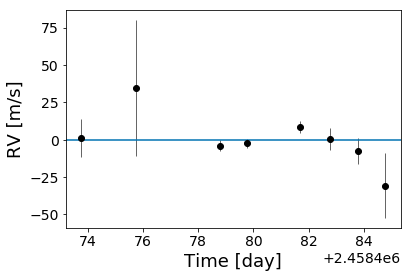

In [5]:
ax = data.plot() # doctest: +SKIP
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [m/s]") # doctest: +SKIP
plt.axhline(0)

In [6]:
np.median(err)

<Quantity 8.03865 m / s>

In [7]:
params = JokerParams(P_min=1*u.day, P_max=20*u.day)

In [8]:
joker = TheJoker(params)

In [9]:
%%time
samples = joker.rejection_sample(data, n_prior_samples=65536)

INFO: 6334 good samples after rejection sampling [thejoker.sampler.sampler]
CPU times: user 6.64 s, sys: 165 ms, total: 6.81 s
Wall time: 5.92 s


CPU times: user 16.6 s, sys: 358 ms, total: 17 s
Wall time: 16.4 s


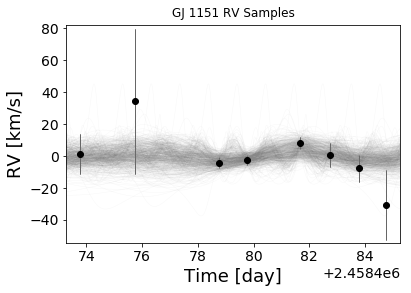

In [16]:
%%time
t_grid = np.linspace(t.min()-0.5, t.max()+0.5, 1024)

ax = data.plot() # doctest: +SKIP

plot_rv_curves(samples[::10], t_grid, rv_unit=u.m/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'));
plt.title('GJ 1151 RV Samples',y=1.01)
ax.set_xlabel("Time [day]") # doctest: +SKIP
ax.set_ylabel("RV [km/s]") # doctest: +SKIP
ax.set_xlim(t.min()-0.5,t.max()+0.5)
ax.set_ylim((rv-err).min().value-2.,(rv+err).max().value+2.)

# plt.savefig('gj1151b_samples.png',bbox_inches='tight')
# plt.savefig('gj1151b_samples.eps',bbox_inches='tight')
plt.savefig('gj1151b_samples.pdf',bbox_inches='tight')


In [ ]:
test = samples.copy()

In [ ]:
plt.xlim(0,40)
plt.axvline(test['K'].value.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(test['K'].value.mean()-test['K'].value.std(),test['K'].value.mean()+test['K'].value.std(),color=colours[2],alpha=0.5)
h = plt.hist(test['K'].value,bins=100,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'Semi-amplitude $K$ (m/s)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b K',y=1.01)
plt.savefig('gj1151b_posterior.png',bbox_inches='tight')

### Now let's calculate the planet's mass

In [ ]:
Ps = samples['P'].to(u.d).value

eccs = samples['e'].value

Ks = samples['K'].to(u.m/u.s).value

nsim = np.size(Ps)
# masses for a generic late-M from https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
Mstar = 0.34 # old
Mstar = 0.167 # https://ui.adsabs.harvard.edu/#abs/2016yCat..18210093N/abstract
dMstar = 0.025
Mstars = np.random.rand(nsim)*dMstar + Mstar-dMstar/2. 


In [ ]:
print(Mstar-dMstar/2.,Mstar+dMstar/2.)

In [ ]:
Msini = 4.919e-3 * (Ps**(1./3.)) * np.sqrt(1.-eccs**2.) * Ks * Mstars**(2./3.) * 317.8  # * 317.8 Jupiter over Earth

In [ ]:
print('Msini: %.2f +- %.2f' % (np.mean(Msini), np.std(Msini)),'M_Earth')

In [ ]:
print(np.percentile(Msini,99))

In [ ]:
plt.xlim(0,40.)
plt.axvline(Msini.mean(),color=colours[2],linewidth=5,label=r'Mean and Sigma')
plt.axvspan(Msini.mean()-Msini.std(),Msini.mean()+Msini.std(),color=colours[2],alpha=0.5)
h = plt.hist(Msini,bins=100,label='PDF',normed=True)

plt.legend()
plt.xlabel(r'$M\, \sin{i}$ ($M_E$)')
plt.ylabel('PDF')
plt.title('Constraints on GJ 1151 b Mass',y=1.01)
plt.savefig('gj1151b_mass.png',bbox_inches='tight')
plt.savefig('gj1151b_mass.pdf',bbox_inches='tight')

In [ ]:
dummy = np.array([samples['P'].value,samples['K'].value]).T
corner.corner(dummy,labels=['P (d)','K (m/s)'],quantiles=[0.16, 0.5, 0.84],
             show_titles=True, title_kwargs={"fontsize": 12},bins=50,range=((0,15),(0,25)));
plt.savefig('cornerplot_k.png',bbox_inches='tight')